# Combined Notebook: MCNN for Crowd Counting and U-Net for Pet Segmentation

In [16]:
# @title Setup and Imports
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from scipy.io import loadmat
from skimage.draw import disk
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

# Part 1: MCNN for Crowd Counting

1.1 Dataset Preparation and Unzipping

In [17]:
# @title Unzip dataset
# !unzip -q "/content/drive/MyDrive/dataset/archive.zip"

replace ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

1.2 Define Paths

In [18]:
# @title Define paths for crowd counting dataset
train_img_dir = "/content/ShanghaiTech/part_A/train_data/images"
train_gt_dir = "/content/ShanghaiTech/part_A/train_data/ground-truth"
test_img_dir = "/content/ShanghaiTech/part_A/test_data/images"
test_gt_dir = "/content/ShanghaiTech/part_A/test_data/ground-truth"

density_map_dir = "/content/density_maps"
os.makedirs(density_map_dir, exist_ok=True)

1.3 Density Map Generator


In [19]:
# @title Density map generator function
def generate_density_map(image, points, sigma=4):
    h, w = image.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(int(point[0]), w - 1)
        y = min(int(point[1]), h - 1)
        rr, cc = disk((y, x), sigma, shape=density.shape)
        density[rr, cc] += 1
    return density

In [20]:
# @title Fixed: Generate and save density maps for training data
train_imgs = sorted(glob(os.path.join(train_img_dir, "*.jpg")))

for img_path in tqdm(train_imgs):
    # Extract filename correctly (handle cases where filename might have multiple dots)
    fname = os.path.splitext(os.path.basename(img_path))[0]  # This is more robust than replace()
    gt_path = os.path.join(train_gt_dir, f"GT_{fname}.mat")

    # Check if ground truth file exists before proceeding
    if not os.path.exists(gt_path):
        print(f"Warning: Ground truth file not found: {gt_path}")
        continue

    try:
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image: {img_path}")
            continue

        density = generate_density_map(image, points)
        np.save(os.path.join(density_map_dir, f"{fname}.npy"), density)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        continue

100%|██████████| 300/300 [00:20<00:00, 14.89it/s]


In [21]:
# @title Crowd counting data generator
class CrowdDataset(tf.keras.utils.Sequence):
    def __init__(self, image_paths, density_paths, batch_size=4, input_size=(224, 224)):
        self.image_paths = image_paths
        self.density_paths = density_paths
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        X = []
        Y = []
        for i in range(self.batch_size):
            index = idx * self.batch_size + i
            image = cv2.imread(self.image_paths[index])
            image = cv2.resize(image, self.input_size)
            image = image.astype(np.float32) / 255.0

            fname = os.path.basename(self.image_paths[index]).replace(".jpg", "")
            density = np.load(self.density_paths[index])
            density = cv2.resize(density, self.input_size)
            density = density.astype(np.float32)
            density *= (np.sum(density) / (np.sum(density) + 1e-6))  # Preserve total count

            X.append(image)
            Y.append(density[..., np.newaxis])
        return np.array(X), np.array(Y)

In [22]:
# @title Define MCNN model architecture
def mcnn(input_shape=(224, 224, 3)):
    def column_block(filters, kernel_size):
        return models.Sequential([
            layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
            layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
            layers.MaxPooling2D()
        ])

    inputs = layers.Input(shape=input_shape)

    # Three columns with different receptive fields
    col1 = column_block(16, 9)(inputs)
    col2 = column_block(20, 7)(inputs)
    col3 = column_block(24, 5)(inputs)

    merged = layers.concatenate([col1, col2, col3])
    x = layers.Conv2D(1, 1, activation='linear', padding='same')(merged)

    # Add an upsampling layer to match the input size
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [23]:
# @title Load data and train MCNN model
train_images = sorted(glob(os.path.join(train_img_dir, "*.jpg")))
train_density = sorted(glob(os.path.join(density_map_dir, "*.npy")))

train_gen = CrowdDataset(train_images, train_density, batch_size=4)

model = mcnn()
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

# Train the model and store history for visualization
history = model.fit(train_gen, epochs=15)
model.save("mcnn_crowd_model.h5")

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8900 - loss: 0.2134
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9342 - loss: 0.0513
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9259 - loss: 0.0599
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9370 - loss: 0.0484
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9337 - loss: 0.0477
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9399 - loss: 0.0443
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9394 - loss: 0.0444
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9374 - loss: 0.0446
Epoch 9/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9439 - loss: 0.0402
Epoch 10/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9383 - loss: 0.0450
Epoch 11/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9342 - loss: 0.0478
Epoch 12/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9414 - 

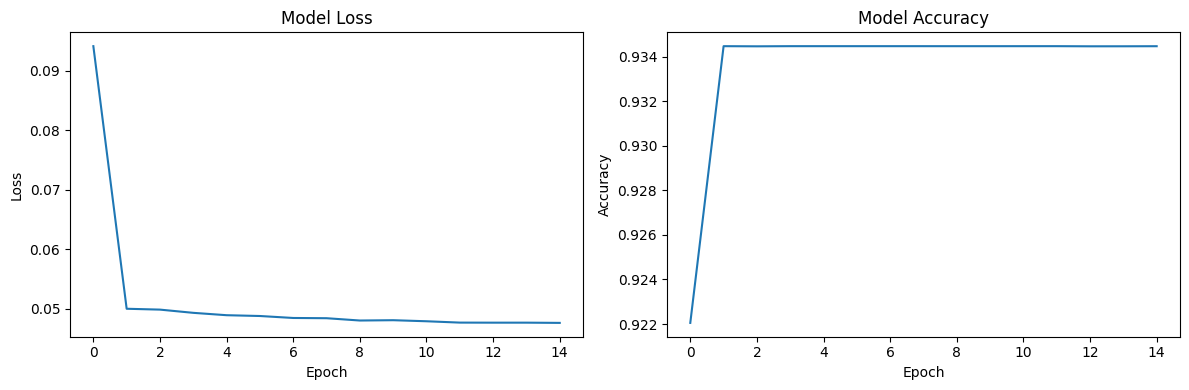

In [24]:
# @title Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [25]:
# @title Evaluate model on test data
test_images = sorted(glob(os.path.join(test_img_dir, "*.jpg")))
test_gt = sorted(glob(os.path.join(test_gt_dir, "*.mat")))

mae = 0
mse = 0
for i in tqdm(range(len(test_images))):
    image = cv2.imread(test_images[i])
    image_resized = cv2.resize(image, (224, 224)).astype(np.float32) / 255.0

    mat = loadmat(test_gt[i])
    points = mat["image_info"][0][0][0][0][0]
    gt_count = len(points)

    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)

    mae += abs(gt_count - pred_count)
    mse += (gt_count - pred_count) ** 2

mae /= len(test_images)
mse = np.sqrt(mse / len(test_images))
print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")

  0%|          | 0/182 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 1/182 [00:01<04:06,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 2/182 [00:01<01:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 4/182 [00:01<00:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 6/182 [00:01<00:37,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▍         | 7/182 [00:02<00:32,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 8/182 [00:02<00:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 9/182 [00:02<00:26,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 11/182 [00:02<00:22,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  7%|▋         | 13/182 [00:02<00:18,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 15/182 [00:02<00:15, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 17/182 [00:02<00:15, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 19/182 [00:03<00:14, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 21/182 [00:03<00:18,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 23/182 [00:03<00:16,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 25/182 [00:03<00:15, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 27/182 [00:03<00:13, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 29/182 [00:04<00:14, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 31/182 [00:04<00:14, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 33/182 [00:04<00:13, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 35/182 [00:04<00:12, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 37/182 [00:04<00:11, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 39/182 [00:04<00:11, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 41/182 [00:05<00:11, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 43/182 [00:05<00:11, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 45/182 [00:05<00:10, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 47/182 [00:05<00:11, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 49/182 [00:05<00:12, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 51/182 [00:05<00:11, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 53/182 [00:06<00:11, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 55/182 [00:06<00:10, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███▏      | 57/182 [00:06<00:09, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 59/182 [00:06<00:10, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 61/182 [00:06<00:09, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 63/182 [00:06<00:10, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 65/182 [00:07<00:10, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 67/182 [00:07<00:10, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 69/182 [00:07<00:09, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 71/182 [00:07<00:09, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 73/182 [00:07<00:08, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 75/182 [00:07<00:08, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 77/182 [00:08<00:09, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 79/182 [00:08<00:08, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 81/182 [00:08<00:09, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 83/182 [00:08<00:08, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 85/182 [00:08<00:08, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 87/182 [00:08<00:08, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 89/182 [00:09<00:08, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 91/182 [00:09<00:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 93/182 [00:09<00:07, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 95/182 [00:09<00:07, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 97/182 [00:09<00:07, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 99/182 [00:09<00:06, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 101/182 [00:10<00:06, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 103/182 [00:10<00:07, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 105/182 [00:10<00:07, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 107/182 [00:10<00:06, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 109/182 [00:10<00:07, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 111/182 [00:11<00:06, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 113/182 [00:11<00:06, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 115/182 [00:11<00:06, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 117/182 [00:11<00:05, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 119/182 [00:11<00:06, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 66%|██████▋   | 121/182 [00:12<00:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 67%|██████▋   | 122/182 [00:12<00:07,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 68%|██████▊   | 123/182 [00:12<00:07,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 124/182 [00:12<00:07,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▊   | 125/182 [00:12<00:07,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 126/182 [00:12<00:07,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 70%|██████▉   | 127/182 [00:13<00:10,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 128/182 [00:13<00:08,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 129/182 [00:13<00:08,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 130/182 [00:13<00:07,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 131/182 [00:13<00:07,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 132/182 [00:13<00:07,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 133/182 [00:13<00:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▎  | 134/182 [00:14<00:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 135/182 [00:14<00:06,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 136/182 [00:14<00:05,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 137/182 [00:14<00:05,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 138/182 [00:14<00:05,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▋  | 139/182 [00:14<00:05,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 140/182 [00:14<00:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 142/182 [00:15<00:04,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▊  | 143/182 [00:15<00:04,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▉  | 144/182 [00:15<00:04,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████▉  | 145/182 [00:15<00:04,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 147/182 [00:15<00:04,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████▏ | 148/182 [00:15<00:03,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 150/182 [00:15<00:03,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 151/182 [00:16<00:03,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▎ | 152/182 [00:16<00:03,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 154/182 [00:16<00:02,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 156/182 [00:16<00:02, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 158/182 [00:16<00:02, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 160/182 [00:16<00:02, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 162/182 [00:17<00:01, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 164/182 [00:17<00:01, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 166/182 [00:17<00:01, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 168/182 [00:17<00:01, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 170/182 [00:17<00:01, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 172/182 [00:18<00:00, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 174/182 [00:18<00:00, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 176/182 [00:18<00:00, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 178/182 [00:18<00:00, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 180/182 [00:18<00:00, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|██████████| 182/182 [00:18<00:00,  9.60it/s]

MAE: 1144.95, RMSE: 1274.11


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


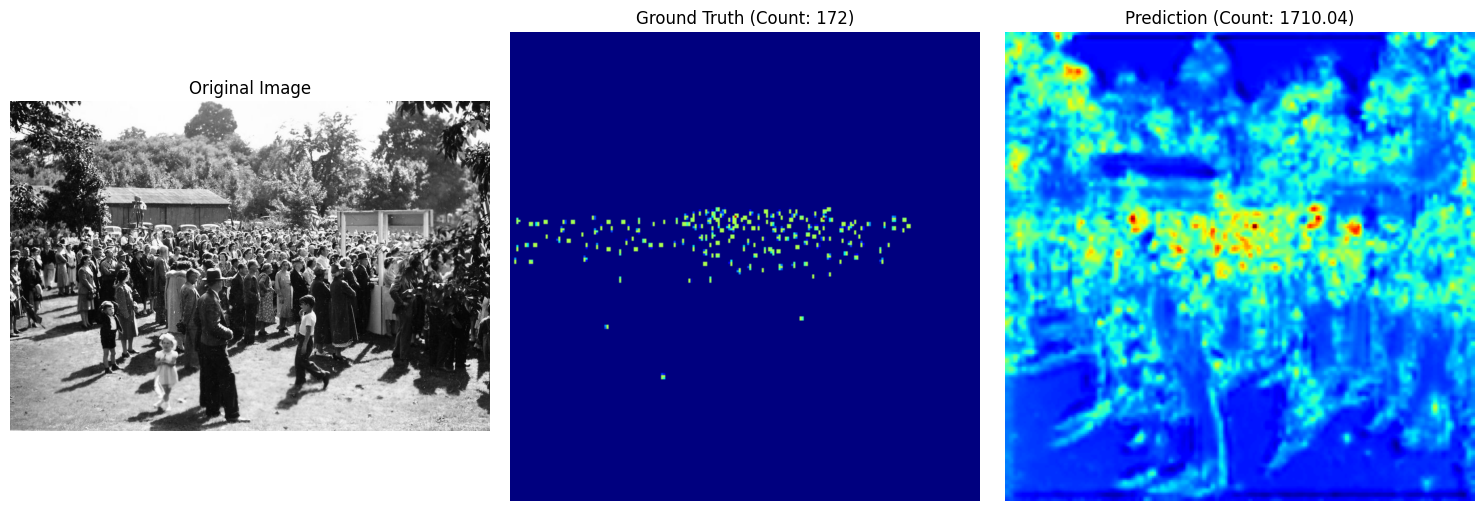

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


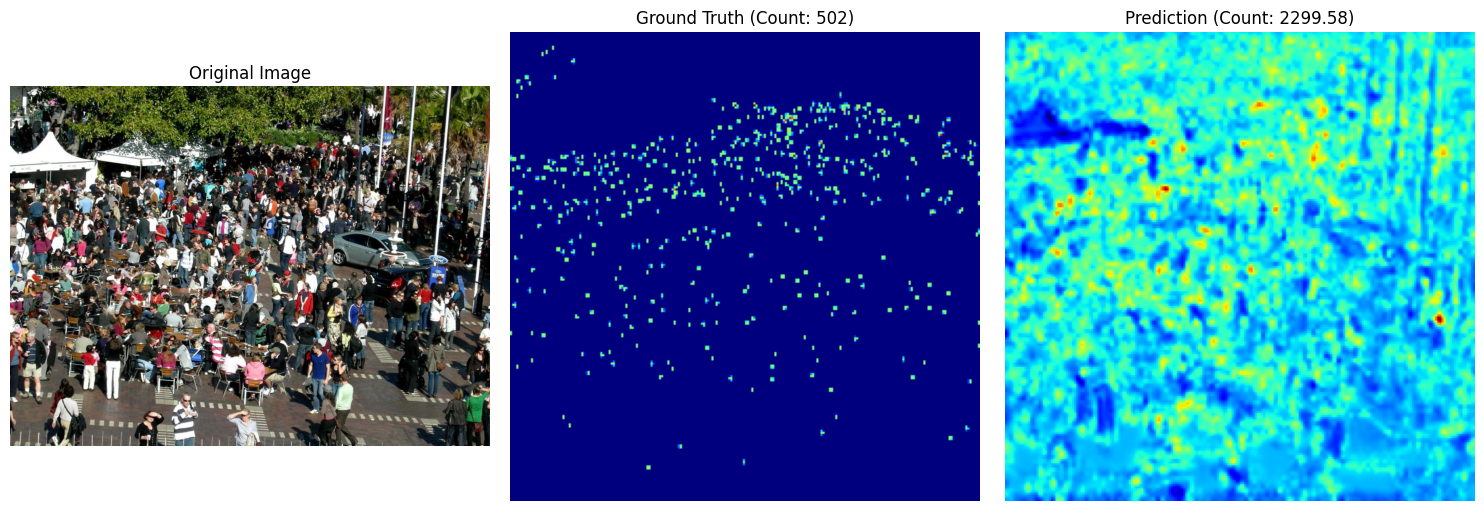

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


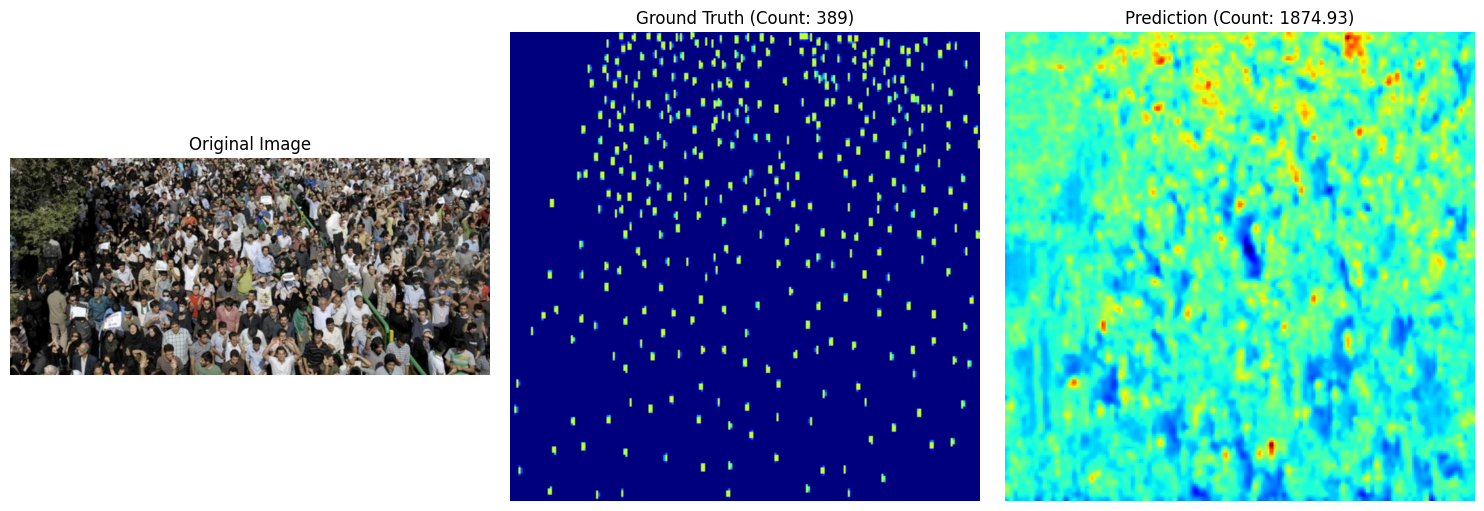

In [26]:
# @title Visualize crowd counting results
def visualize_result(image_path, mat_path, model, input_size=(224, 224)):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, input_size).astype(np.float32) / 255.0

    mat = loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]
    gt_density = generate_density_map(image, points)
    gt_resized = cv2.resize(gt_density, input_size)

    pred_density = model.predict(np.expand_dims(image_resized, axis=0))[0, ..., 0]
    pred_count = np.sum(pred_density)
    gt_count = len(points)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_resized, cmap='jet')
    plt.title(f"Ground Truth (Count: {gt_count})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_density, cmap='jet')
    plt.title(f"Prediction (Count: {pred_count:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize results for first 3 test images
for i in range(3):
    visualize_result(test_images[i], test_gt[i], model)

### Part 2: U-Net for Pet Segmentation

In [28]:
# @title Define U-Net model architecture
def conv_block(x, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(x, num_filters):
    f = conv_block(x, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet():
    inputs = tf.keras.Input(shape=(128, 128, 3))
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    b1 = conv_block(p3, 512)
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d3)
    return tf.keras.Model(inputs, outputs)

model_unet = build_unet()
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_unet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_11[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_13[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_14[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    131,200 │ conv2d_16[0][0] 

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# @title Train the U-Net model
steps_per_epoch = TRAIN_LENGTH // 32

history_unet = model_unet.fit(train, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 289ms/step - accuracy: 0.5974 - loss: 0.6660
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.7700 - loss: 0.4984
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - accuracy: 0.7936 - loss: 0.4510
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 295ms/step - accuracy: 0.8267 - loss: 0.3986
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.8497 - loss: 0.3472


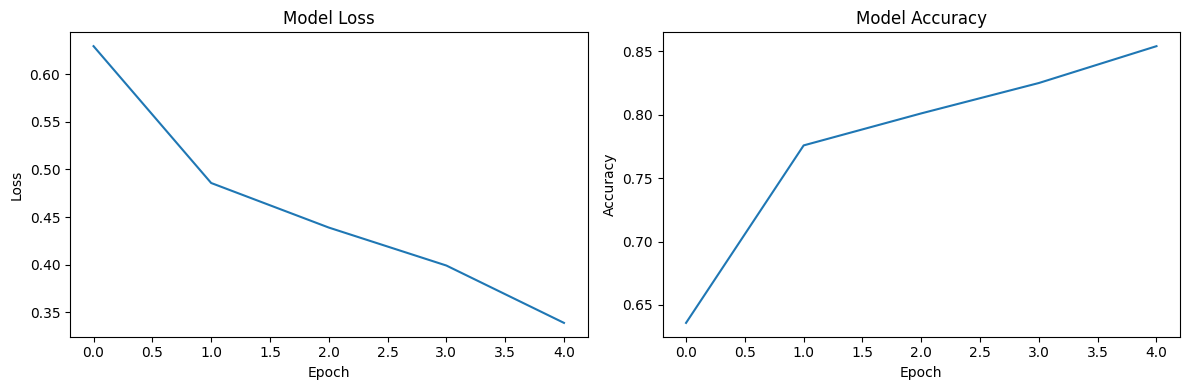

In [30]:
# @title Plot U-Net training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_unet.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history_unet.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


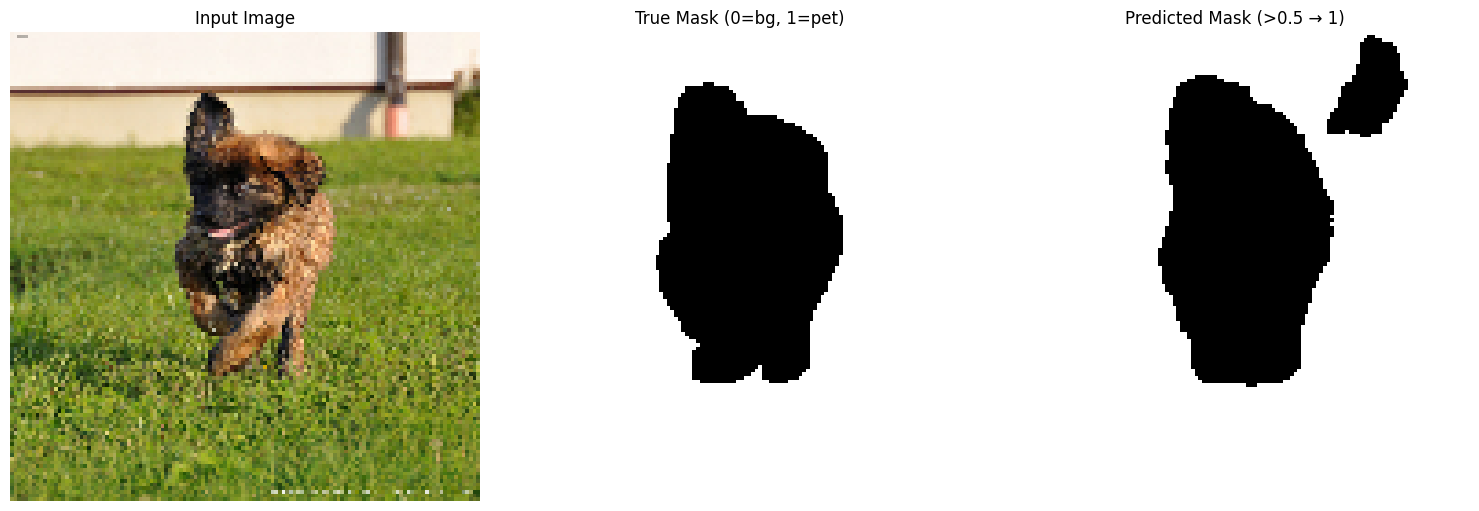

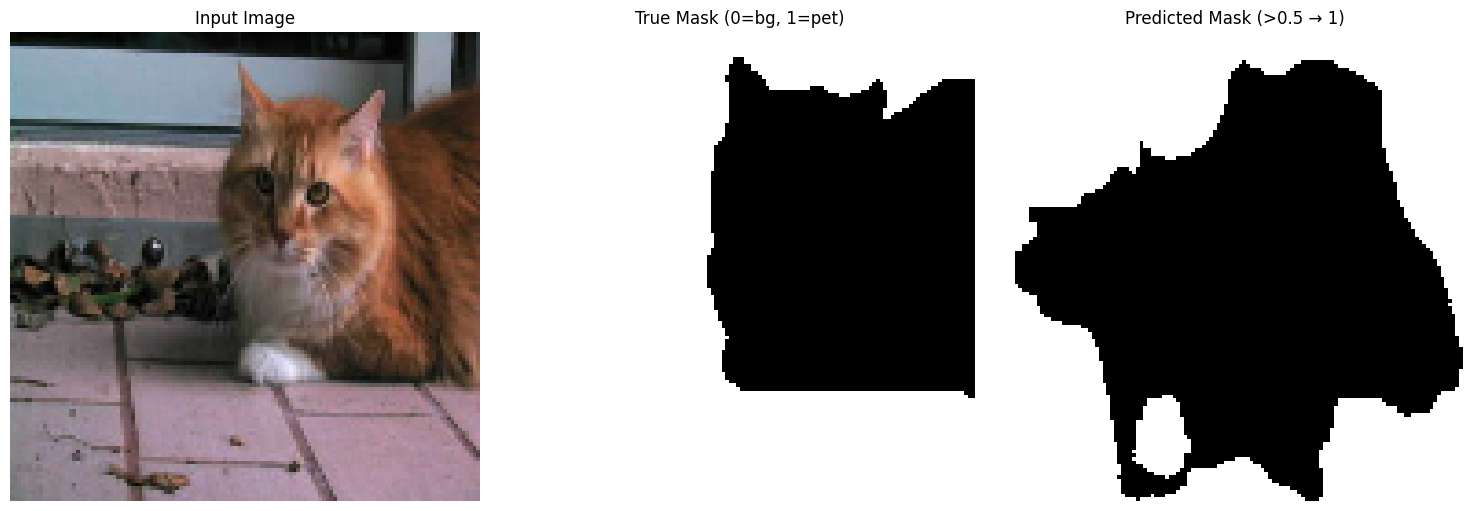

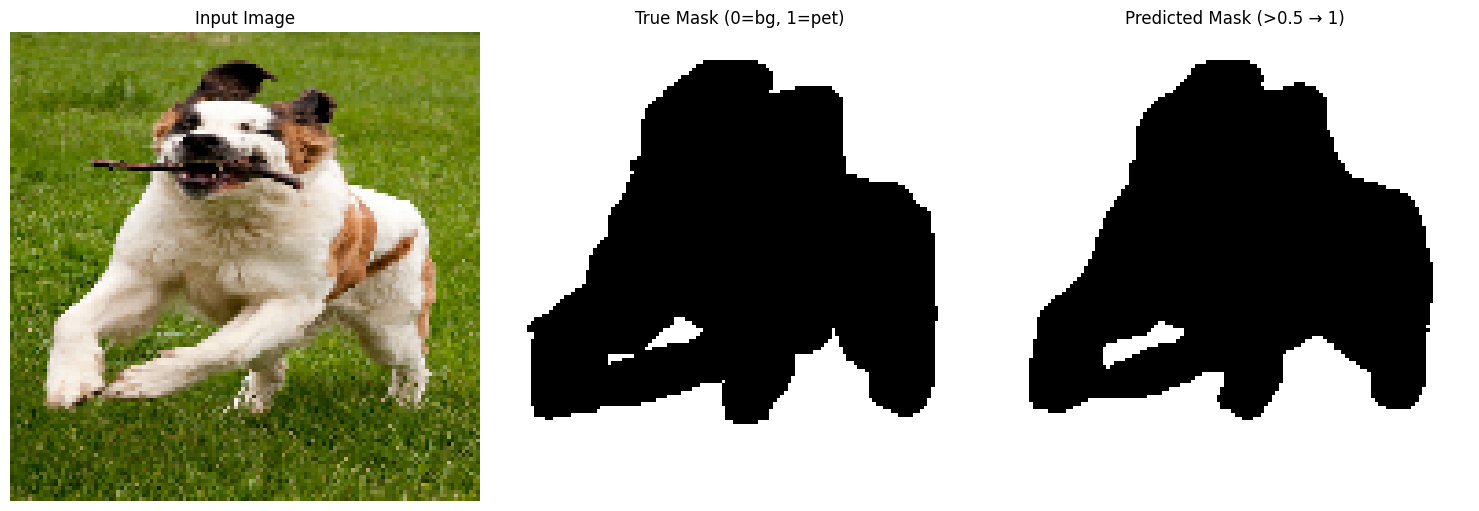

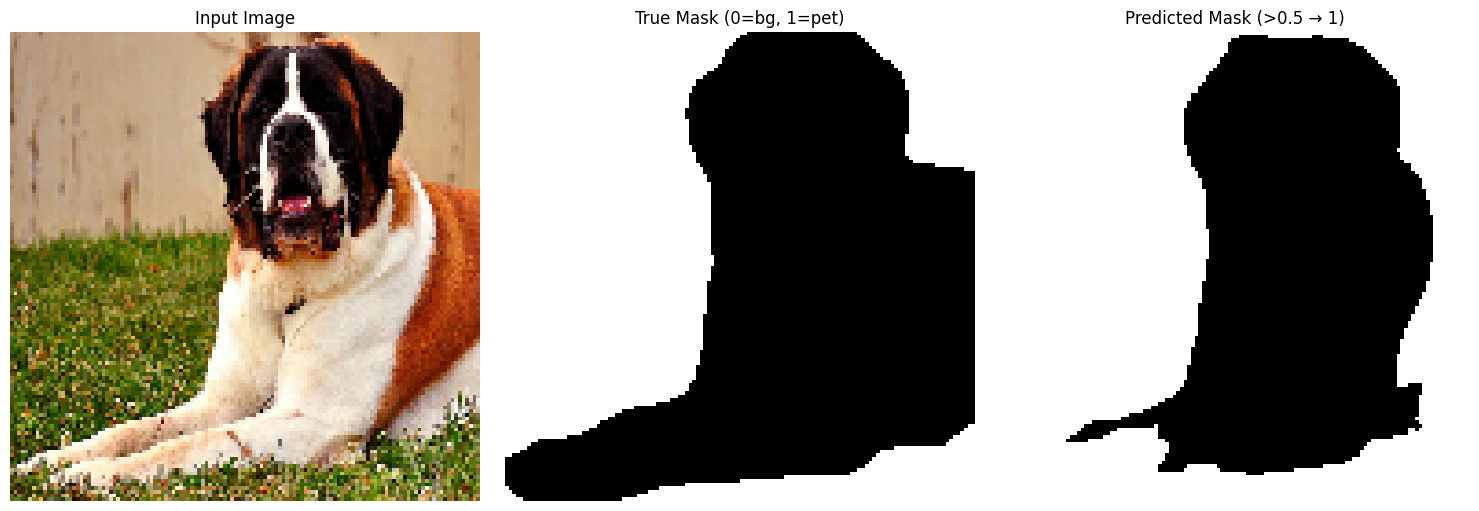

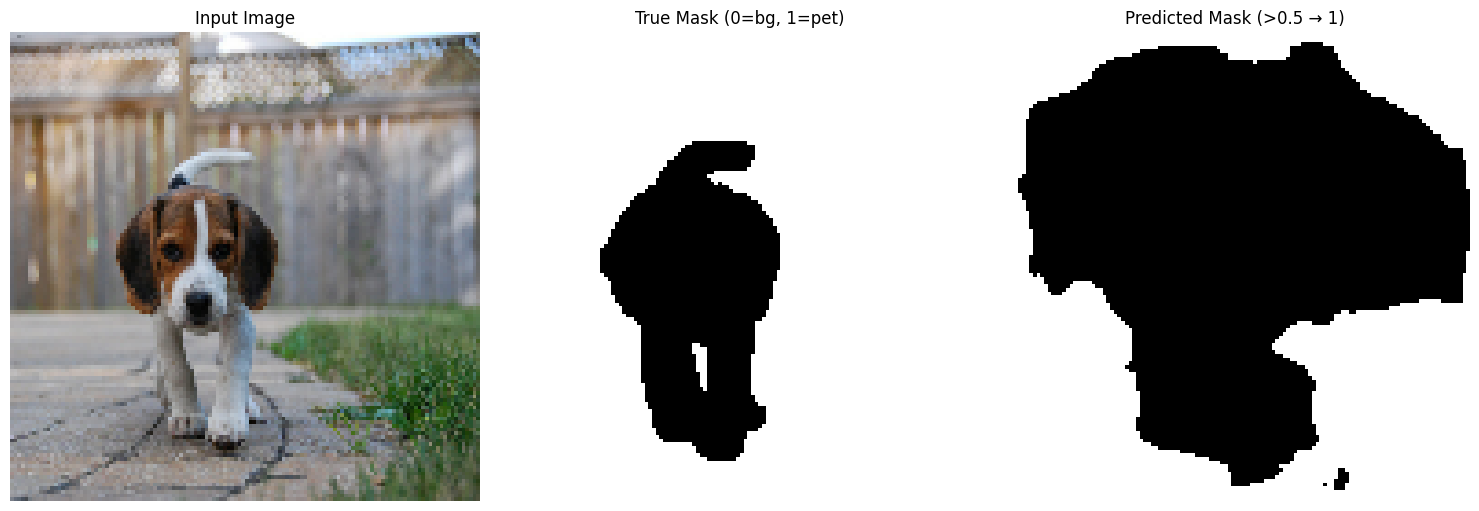

In [31]:
# @title Visualize segmentation results
def display_sample_with_labels(image, true_mask, pred_mask):
    pred_mask_bin = tf.where(pred_mask > 0.5, 1.0, 0.0)

    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title("True Mask (0=bg, 1=pet)")
    plt.imshow(tf.squeeze(true_mask), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    # Predicted mask (thresholded)
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (>0.5 → 1)")
    plt.imshow(tf.squeeze(pred_mask_bin), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions for 5 images
for images, masks in test.take(1):
    preds = model_unet.predict(images)
    for i in range(5):
        display_sample_with_labels(images[i], masks[i], preds[i])

In [32]:
# @title Calculate additional metrics (IoU and Dice)
def calculate_iou(y_true, y_pred):
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.clip_by_value(y_true + y_pred, 0, 1))
    return intersection / (union + 1e-7)

def calculate_dice(y_true, y_pred):
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Calculate metrics on test set
total_iou = 0
total_dice = 0
count = 0

for images, masks in test:
    preds = model_unet.predict(images)
    batch_iou = calculate_iou(masks, preds)
    batch_dice = calculate_dice(masks, preds)
    total_iou += batch_iou
    total_dice += batch_dice
    count += 1

mean_iou = total_iou / count
mean_dice = total_dice / count

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


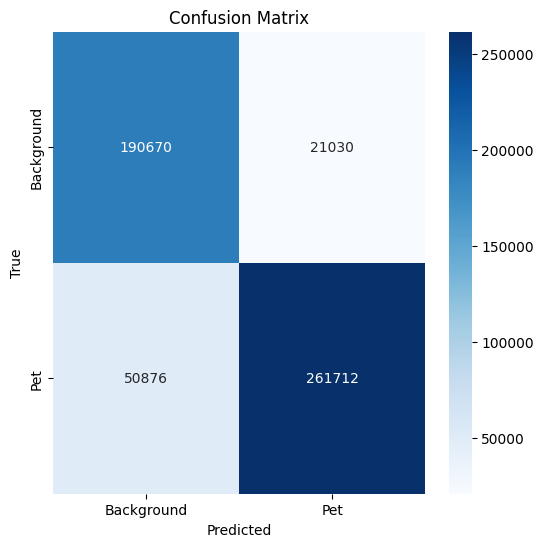

In [33]:
# @title Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions and true values for a batch
for images, masks in test.take(1):
    preds = model_unet.predict(images)
    y_true = masks.numpy().flatten()
    y_pred = (preds.flatten() > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Pet'],
            yticklabels=['Background', 'Pet'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# @title Print summary of both models' performance
print("=== Crowd Counting Model (MCNN) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {mse:.2f}")

print("\n=== Pet Segmentation Model (U-Net) ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Final Accuracy: {history_unet.history['accuracy'][-1]:.4f}")

=== Crowd Counting Model (MCNN) ===
Mean Absolute Error (MAE): 1144.95
Root Mean Squared Error (RMSE): 1274.11

=== Pet Segmentation Model (U-Net) ===
Mean IoU: 0.7726
Mean Dice Coefficient: 0.8714
Final Accuracy: 0.8541
